# Классификация и градиентные спуски :) 

В этой тетрадке мы попробуем немного посмотреть на то, как работают разные градиентные спуски. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings         # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings("ignore") # обработка всевозсожных warnings путем их игнорирования

plt.style.use('ggplot')
%matplotlib inline

In [3]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    ROOT = Path("/content/drive/My Drive/HSE_DL_2021/02_week/")
    
    assert ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(ROOT))
else:
    ROOT = Path(".")

# 1. Выборка

Делать всё это мы будем на животных. Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [4]:
X = pd.read_csv(f'{ROOT}/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv(f'{ROOT}/y_cat.csv', sep = '\t', index_col=0,  names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [5]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [6]:
target = target.values
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [8]:
len(y)

26729

In [9]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


In [11]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# 2. Архитектурка

In [12]:
import torch
import torch.nn as nn            # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F  # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

Функция для рисования графиков

In [13]:
def plot(histories):
    plt.figure(figsize=(16,10))
    
    for name, val_loss in histories:
        plt.plot(val_loss, label=name)

    plt.legend()

 Соберем архитектуру модели

In [14]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
BATCH_SIZE = 1000
EPOCHS = 100
LEARNING_RATE = 0.001 # большие буквы - что не меняем

def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.Sigmoid(),
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax()
    )

    return model

Напишем функцию, которая будет тренировать нейронную сеть. Функция имеет 2 логические части: первая - тренировочная, вторая - валидационная, другими словами, та, на которой вычисляется ошибка и сравнивается с ошибкой на тренировочных данных

In [15]:
def run_train(model, optimizer, criterion, scheduler=None):
    train_loss_values = []
    train_accuracy_values = []
    valid_loss_values = []
    valid_accuracy = []
    lr_history = []

    model.train()
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()
            
            # run model on the chosen batch
            output = model(features)

            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()

            # manual accuracy calculation; no torch lightning
            acc = (output.argmax(dim=1)==label).sum() / len(label)

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)


        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d,  train_loss: %f, train_accuracy: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        model.eval()
        # Run validation
        running_loss = []
        running_acc = []
        with torch.no_grad(): # in validation loop we do not need gradients calculation; so switch it off
            for features, label in test_loader:
                output = model(features)
                
                # Calculate error ana accuracy
                loss = criterion(output, label)
                acc = (output.argmax(dim=1)==label).sum() / len(label)

                running_loss.append(loss.item())
                running_acc.append(acc)

            valid_loss_values.append(np.mean(running_loss))
            valid_accuracy.append(np.mean(running_acc))
            if epoch % 20 == 0:
                print('EPOCH %d, valid_loss: %f, valid_accuracy: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))

        if scheduler is not None:
            # Decay Learning Rate
            scheduler.step()
            lr_history.append(scheduler.get_last_lr())

    if scheduler is not None:
        return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy, lr_history
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

Создадим PyTorch `Dataloader`. Объект DataLoader принимает на вход датасет и ряд параметров, задающих процедуру формирования батча данных.

Основным входным параметром `Dataloader` является объект PyTorch `Dataset`. Он нужен для доступа к элементы данных по конкретному индексу. 

На первый взгляд такая конструкция может показаться странной и излишней. Однако к ней просто нужно привыкнуть и со временем станет понятно насколько она удобна и лаконична. В силу своей гибкости она позволяет формировать размер и структуру батча по желанию, а также собирать батч из заранее выбранных элементов данных. Такая кастомная сборка батча может пригодиться, например, при работе с последовательными данными, такими как предложения в тексте, имеющими разную длину. 

In [16]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.LongTensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.LongTensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

# 3. Оптимизация 

### SGD 

In [17]:
# Первая простенькая моделька 
model1 = build_model()
list(model1.parameters())[0].shape

torch.Size([25, 37])

In [18]:


# инициализируем SGD optimizer
sgd = optim.SGD(model1.parameters(), lr=LEARNING_RATE)

# инициализируем Loss function (функцию потерь)
criterion = nn.CrossEntropyLoss()

# запускаем процесс обучения
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train(model1, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.416871, train_accuracy: 0.065338
EPOCH 0, valid_loss: 1.416177, valid_accuracy: 0.065579
EPOCH 20,  train_loss: 1.394041, train_accuracy: 0.065997
EPOCH 20, valid_loss: 1.393570, valid_accuracy: 0.065579
EPOCH 40,  train_loss: 1.376155, train_accuracy: 0.403161
EPOCH 40, valid_loss: 1.375723, valid_accuracy: 0.404994
EPOCH 60,  train_loss: 1.362065, train_accuracy: 0.403307
EPOCH 60, valid_loss: 1.361646, valid_accuracy: 0.404994
EPOCH 80,  train_loss: 1.350775, train_accuracy: 0.403380
EPOCH 80, valid_loss: 1.350498, valid_accuracy: 0.404994


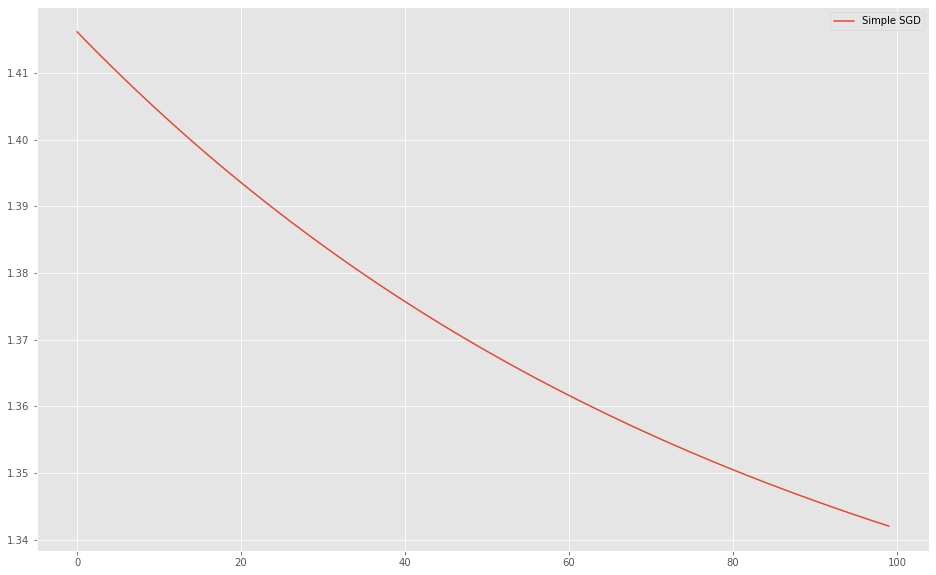

In [19]:
plot([('Simple SGD', valid_loss_values)])

### Nesterov Momentum

In [20]:
# Первая простенькая моделька 
model2 = build_model()

# инициализируем SGD optimizer
sgd = optim.SGD(model2.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

# запускаем процесс обучения
train_loss_values2, train_accuracy_values2, valid_loss_values2, valid_accuracy2 = run_train(model2, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.358195, train_accuracy: 0.402868
EPOCH 0, valid_loss: 1.355479, valid_accuracy: 0.404994
EPOCH 20,  train_loss: 1.310172, train_accuracy: 0.402575
EPOCH 20, valid_loss: 1.309016, valid_accuracy: 0.404994
EPOCH 40,  train_loss: 1.299463, train_accuracy: 0.403307
EPOCH 40, valid_loss: 1.298870, valid_accuracy: 0.404994
EPOCH 60,  train_loss: 1.294609, train_accuracy: 0.402794
EPOCH 60, valid_loss: 1.294415, valid_accuracy: 0.404994
EPOCH 80,  train_loss: 1.292106, train_accuracy: 0.403087
EPOCH 80, valid_loss: 1.291852, valid_accuracy: 0.404994


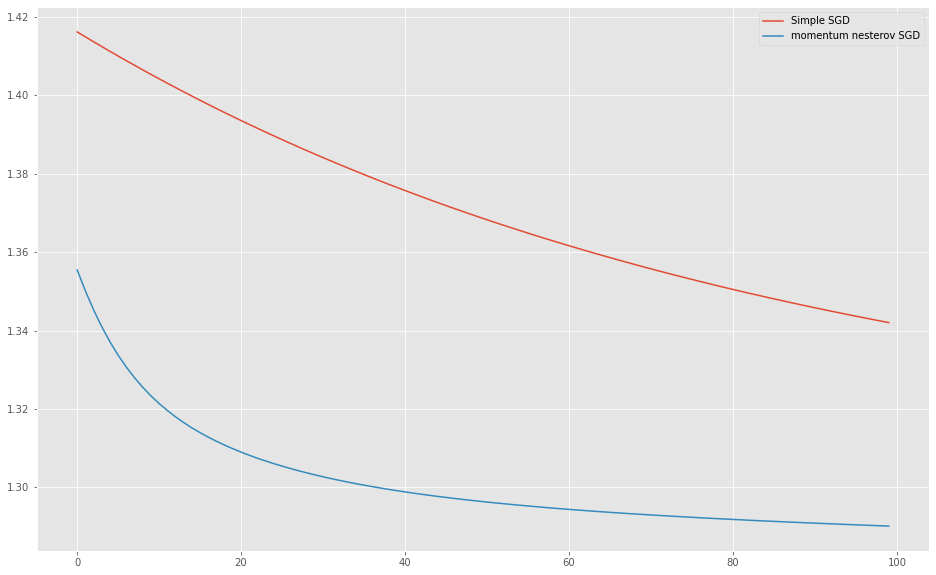

In [26]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2)])


### RMSprop 

In [27]:
# Первая простенькая моделька 
model3 = build_model()

# инициализируем SGD optimizer
rmsprop = optim.RMSprop(model3.parameters(), lr=LEARNING_RATE, alpha=0.9, eps=1e-08)

# запускаем процесс обучения
train_loss_values3, train_accuracy_values3, valid_loss_values3, valid_accuracy3 = run_train(model3, optimizer=rmsprop, criterion=criterion)

EPOCH 0,  train_loss: 1.382004, train_accuracy: 0.310736
EPOCH 0, valid_loss: 1.353539, valid_accuracy: 0.404994
EPOCH 20,  train_loss: 1.128265, train_accuracy: 0.612185
EPOCH 20, valid_loss: 1.132287, valid_accuracy: 0.606378
EPOCH 40,  train_loss: 1.125850, train_accuracy: 0.613690
EPOCH 40, valid_loss: 1.131608, valid_accuracy: 0.606081
EPOCH 60,  train_loss: 1.123498, train_accuracy: 0.611622
EPOCH 60, valid_loss: 1.127807, valid_accuracy: 0.603136
EPOCH 80,  train_loss: 1.103287, train_accuracy: 0.635190
EPOCH 80, valid_loss: 1.108262, valid_accuracy: 0.628231


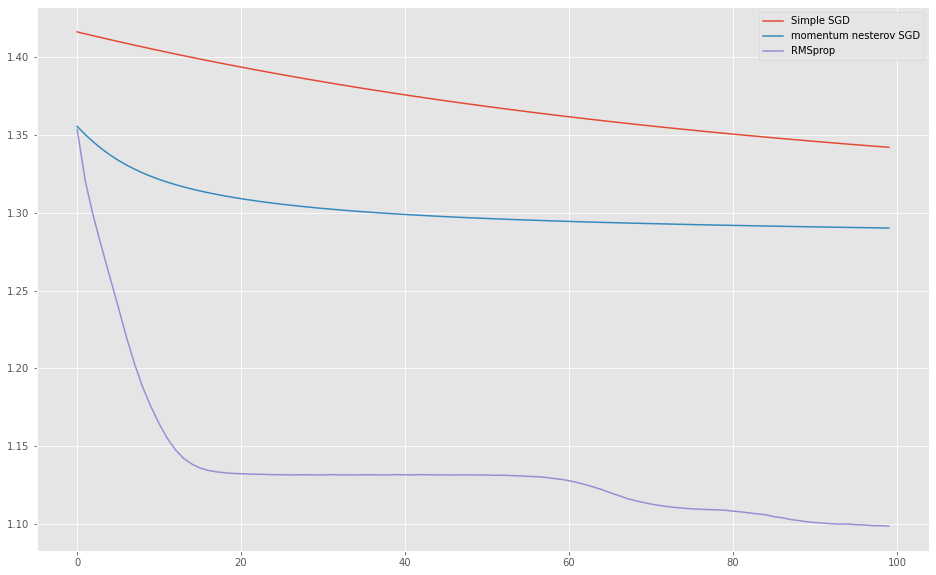

In [28]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3)])


### Adam 

In [29]:
# Первая простенькая моделька 
model4 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model4.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)

# запускаем процесс обучения
train_loss_values4, train_accuracy_values4, valid_loss_values4, valid_accuracy4 = run_train(model4, optimizer=adam, criterion=criterion)

EPOCH 0,  train_loss: 1.376721, train_accuracy: 0.403014
EPOCH 0, valid_loss: 1.354196, valid_accuracy: 0.404994
EPOCH 20,  train_loss: 1.131487, train_accuracy: 0.612854
EPOCH 20, valid_loss: 1.136256, valid_accuracy: 0.606896
EPOCH 40,  train_loss: 1.126014, train_accuracy: 0.614806
EPOCH 40, valid_loss: 1.132364, valid_accuracy: 0.606414
EPOCH 60,  train_loss: 1.125493, train_accuracy: 0.614463
EPOCH 60, valid_loss: 1.131496, valid_accuracy: 0.606914
EPOCH 80,  train_loss: 1.124872, train_accuracy: 0.614584
EPOCH 80, valid_loss: 1.130157, valid_accuracy: 0.605303


In [33]:
# Adamw
model5 = build_model()

# инициализируем SGD optimizer
adam = optim.AdamW(model5.parameters(), lr=LEARNING_RATE)

# запускаем процесс обучения
train_loss_values5, train_accuracy_values5, valid_loss_values5, valid_accuracy5 = run_train(model5, optimizer=adam, criterion=criterion)

EPOCH 0,  train_loss: 1.367103, train_accuracy: 0.402648
EPOCH 0, valid_loss: 1.342651, valid_accuracy: 0.404994
EPOCH 20,  train_loss: 1.130234, train_accuracy: 0.613286
EPOCH 20, valid_loss: 1.135431, valid_accuracy: 0.606378
EPOCH 40,  train_loss: 1.126959, train_accuracy: 0.613789
EPOCH 40, valid_loss: 1.132267, valid_accuracy: 0.606914
EPOCH 60,  train_loss: 1.126282, train_accuracy: 0.613696
EPOCH 60, valid_loss: 1.131511, valid_accuracy: 0.606581
EPOCH 80,  train_loss: 1.123708, train_accuracy: 0.615574
EPOCH 80, valid_loss: 1.129947, valid_accuracy: 0.605636


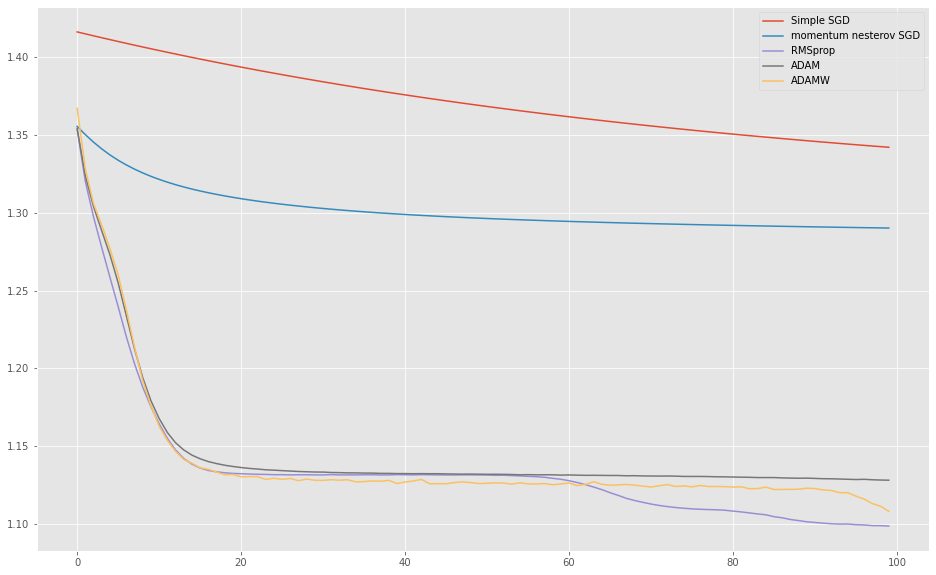

In [35]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAMW', train_loss_values5)])


# 4. Стратегии с постепенным понижением lr 

![](https://raw.githubusercontent.com/FUlyankin/neural_nets_econ/master/2019/sem_2/ahaha.jpg)

In [36]:
# функция для картинок, чтобы видеть как скорость обученя меняется от эпохи к эпохе
def plot_learning_rate(lr_history):
    fig = plt.figure()
    plt.plot(range(1, EPOCHS+1), lr_history, label='learning rate')
    plt.xlabel("epoch")
    plt.xlim([1, epochs+1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title("Learning rate")
    plt.show()

Стартовую скорость обучения специально берём большой! 

In [37]:
INIT_LR = 0.1  # берём lr намеренно большим

In [38]:
len(train_loader)

22

In [39]:
from torch.optim.lr_scheduler import StepLR # алгоритм понижения LR


# Первая простенькая моделька 
model5 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model5.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = StepLR(adam, step_size=50, gamma=0.5)

# запускаем процесс обучения
train_loss_values5, train_accuracy_values5, valid_loss_values5, valid_accuracy5, lr_history5 = run_train(model5, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.174617, train_accuracy: 0.558445
EPOCH 0, valid_loss: 1.138199, valid_accuracy: 0.605453
EPOCH 20,  train_loss: 1.110369, train_accuracy: 0.628334
EPOCH 20, valid_loss: 1.126623, valid_accuracy: 0.609953
EPOCH 40,  train_loss: 1.096588, train_accuracy: 0.644352
EPOCH 40, valid_loss: 1.126816, valid_accuracy: 0.613101
EPOCH 60,  train_loss: 1.082110, train_accuracy: 0.660703
EPOCH 60, valid_loss: 1.129497, valid_accuracy: 0.607453
EPOCH 80,  train_loss: 1.080118, train_accuracy: 0.661857
EPOCH 80, valid_loss: 1.132716, valid_accuracy: 0.603914


In [40]:
adam = optim.SGD(model5.parameters(), lr=INIT_LR)
scheduler = StepLR(adam, step_size=2, gamma=0.1)

for i in range(10):
    print(i+1, scheduler.get_last_lr())
    scheduler.step()

1 [0.1]
2 [0.1]
3 [0.010000000000000002]
4 [0.010000000000000002]
5 [0.0010000000000000002]
6 [0.0010000000000000002]
7 [0.00010000000000000003]
8 [0.00010000000000000003]
9 [1.0000000000000004e-05]
10 [1.0000000000000004e-05]


NameError: name 'epochs' is not defined

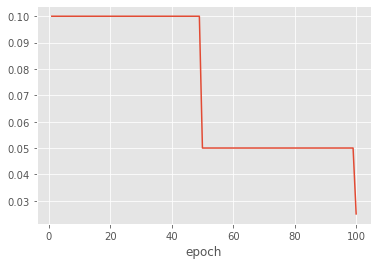

In [41]:
# Смотрим как скорость обучения по немного понижалась
plot_learning_rate(lr_history5)

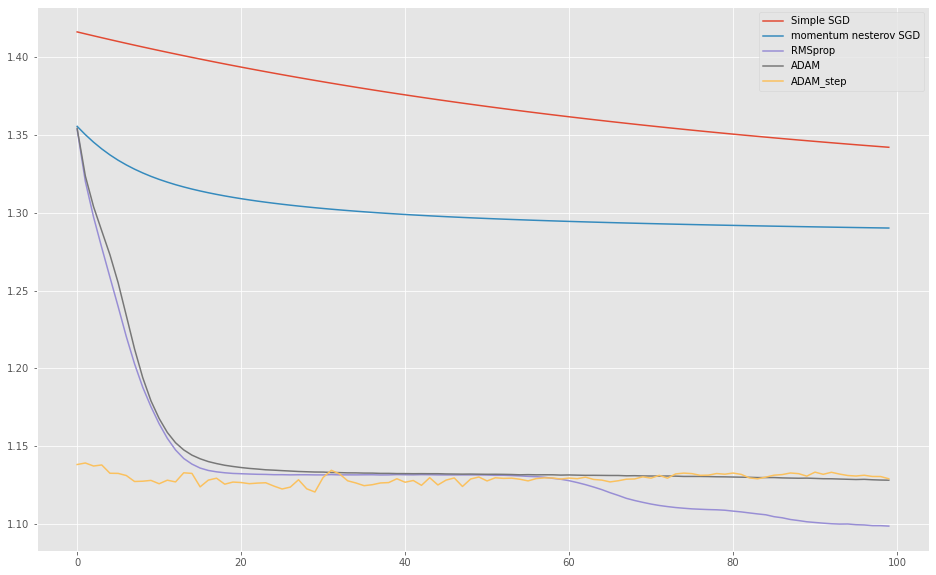

In [42]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5)])

Попробуем ещё вариант!

In [45]:
from torch.optim.lr_scheduler import MultiStepLR


# Первая простенькая моделька 
model6 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model6.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = MultiStepLR(adam, milestones=[30,80], gamma=0.1)

# запускаем процесс обучения
train_loss_values6, train_accuracy_values6, valid_loss_values6, valid_accuracy6, lr_history6 = run_train(model6, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.178954, train_accuracy: 0.557319
EPOCH 0, valid_loss: 1.141697, valid_accuracy: 0.600823
EPOCH 20,  train_loss: 1.074488, train_accuracy: 0.663104
EPOCH 20, valid_loss: 1.092967, valid_accuracy: 0.645363
EPOCH 40,  train_loss: 1.042331, train_accuracy: 0.703190
EPOCH 40, valid_loss: 1.087684, valid_accuracy: 0.650678
EPOCH 60,  train_loss: 1.034150, train_accuracy: 0.712945
EPOCH 60, valid_loss: 1.087867, valid_accuracy: 0.651975
EPOCH 80,  train_loss: 1.030131, train_accuracy: 0.717205
EPOCH 80, valid_loss: 1.088489, valid_accuracy: 0.652160


NameError: name 'epochs' is not defined

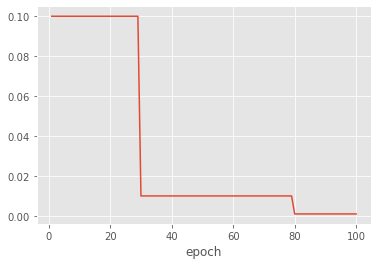

In [44]:
# Смотрим как скорость обучения по немного понижалась
plot_learning_rate(lr_history6)

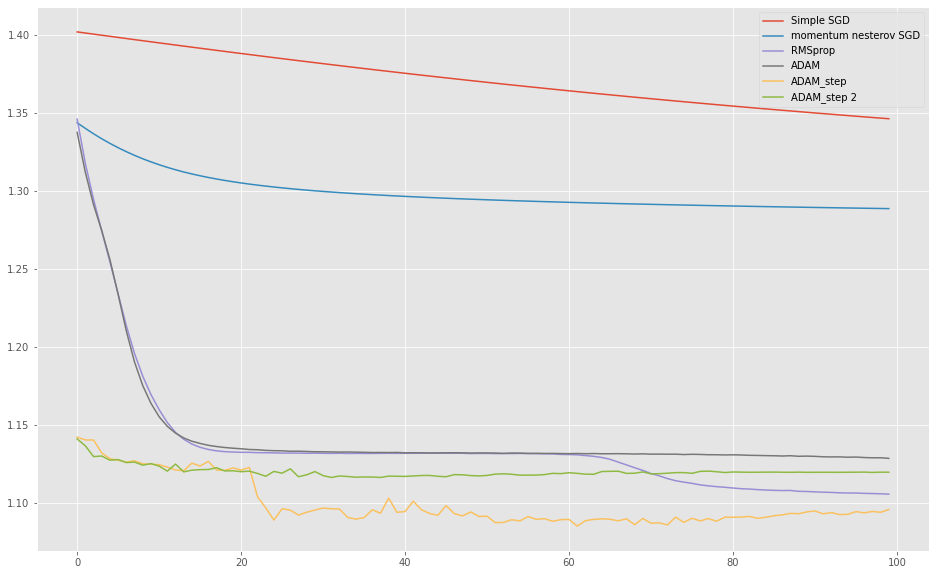

In [126]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5),
      ('ADAM_step 2', valid_loss_values6)])

Существует множество различных Scheduler`ов. Полный список можно найти на [странице](https://pytorch.org/docs/stable/optim.html) в разделе "How to adjust learning rate"

Великолепное описание различных Scheduler`ов и как их применять можно найти по [ссылке](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/)

## Авторские права и почиташки 

* Для создания тетрадки использовался [вот этот мануал](https://github.com/sukilau/Ziff-deep-learning/blob/master/3-CIFAR10-lrate/CIFAR10-lrate.ipynb), адаптированный под PyTorch

##   Поиграться при желании
Пришло время заняться исследованиями! На лекции мы с вами обсудили, что сегодня люди ставят довольно большое число разных экспериментов с циклической скоростью обучения. Делают они это, чтобы как-то соскальзывать с сёдел и выбираться из локальных минимумов.  В этом задании вам надо будет немного поэкспериментировать с такими скоростями обучения. Предлагается поизучать [Scheduler`ы](https://pytorch.org/docs/stable/optim.html), реализованные в PyTorch и выбрать 2-3 для сравнения с рассмотренными вариантами на семинаре

Вообще поощряются любые эксперименты. Не забывайте строить картинки. Можете как-то видоизменить архитектуру сетки. Например, добавить какие-то новые слои или сделать её глубже. Эксперименты можно оформлять прямо в этой тетрадке. Её же и присылайте.

Если хочется вдохновения, [в этой статье](https://www.jeremyjordan.me/nn-learning-rate/) можно найти много разных вариантов пересчёта скорости обучения. Есть варианты с циклами и даже косинусами! Единственное, что код в статье написан на Keras, но это никак не мешает изучить суть алгоритмов. Еще одна полезная [ссылка](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/), которую я уже приводил выше

Плодотворных экспериментов :) 

In [ ]:
# ваш код